<a href="https://colab.research.google.com/github/aaghouse/Cybersecurity_ML/blob/main/cyber_ml_capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
network = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AIML/capstone/capstone-dataset/Train_Test_Network.csv')
network.tail()



Mounted at /content/drive


,ts,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,...,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
461038,1556340862,192.168.1.32,33108,176.28.50.165,80,tcp,-,0.000000,0,0,...,0,0,-,-,-,-,-,-,1,xss
461039,1556423390,192.168.1.33,37242,34.230.157.88,443,tcp,-,0.000000,0,0,...,0,0,-,-,-,-,-,-,1,ransomware
461040,1556436603,192.168.1.37,4444,192.168.1.193,49178,tcp,-,290.371539,101568,2592,...,0,0,-,-,-,-,-,-,1,backdoor
461041,1556540442,192.168.1.31,60816,104.98.29.100,443,tcp,-,23.190902,32,31,...,0,0,-,-,-,-,-,-,1,mitm
461042,1556540442,192.168.1.31,41054,151.101.24.64,443,tcp,-,22.872314,32,31,...,0,0,-,-,-,-,-,-,1,mitm


In [2]:
print(network['type'].value_counts())

normal        300000
scanning       20000
dos            20000
injection      20000
ddos           20000
password       20000
xss            20000
ransomware     20000
backdoor       20000
mitm            1043
Name: type, dtype: int64


In [3]:
print(network.columns)

Index(['ts', 'src_ip', 'src_port', 'dst_ip', 'dst_port', 'proto', 'service',
       'duration', 'src_bytes', 'dst_bytes', 'conn_state', 'missed_bytes',
       'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'dns_query',
       'dns_qclass', 'dns_qtype', 'dns_rcode', 'dns_AA', 'dns_RD', 'dns_RA',
       'dns_rejected', 'ssl_version', 'ssl_cipher', 'ssl_resumed',
       'ssl_established', 'ssl_subject', 'ssl_issuer', 'http_trans_depth',
       'http_method', 'http_uri', 'http_version', 'http_request_body_len',
       'http_response_body_len', 'http_status_code', 'http_user_agent',
       'http_orig_mime_types', 'http_resp_mime_types', 'weird_name',
       'weird_addl', 'weird_notice', 'label', 'type'],
      dtype='object')


In [4]:
# All major included libraries and modules are in this section of the code.
!pip install maxminddb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import maxminddb
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler#, PolynomialFeatures
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.0/87.0 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.9/807.9 kB 15.9 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [5]:
# This code reviews the input source and destination IP's and maps it to the respective region where it originated or destined
# Eventually used to display as graph. This is to review any suspitious countries intrution right off the EDA phase to flag as
# a security threat. Example of these red flag regions could include black listed countries for unknown/unwarrented traffic.


mmdb_file_path = '/content/drive/My Drive/Colab Notebooks/AIML/capstone/capstone-dataset/GeoLite2-Country.mmdb'

# Open the MMDB file
with maxminddb.open_database(mmdb_file_path) as reader:
    # Load your DataFrame or create one with IP addresses
    # For example, let's assume you have a DataFrame with an 'ip_address' column
    # df = pd.read_csv('your_data.csv')

    # Function to perform IP address lookup and return location information
    def ip_to_location(ip):
        try:
            result = reader.get(ip)
            if result:
                return {
                    'country': result.get('country', {}).get('iso_code')#, 'N/A')
                    #'country': result.get('country', {}).get('iso_code', 'N/A')#,
                    #'city': result.get('city', {}).get('names', {}).get('en', 'N/A'),
                    #'latitude': result.get('location', {}).get('latitude', 'N/A'),
                    #'longitude': result.get('location', {}).get('longitude', 'N/A')
                }
            else:
                return {'country': 'N/A'}#, 'city': 'N/A', 'latitude': 'N/A', 'longitude': 'N/A'}
        except Exception as e:
            return {'country': 'N/A'}#, 'city': 'N/A', 'latitude': 'N/A', 'longitude': 'N/A'}

    # Apply the 'ip_to_location' function to the DataFrame to create new columns
    network['src_country'] = network['src_ip'].apply(ip_to_location)
    network['dst_country'] = network['dst_ip'].apply(ip_to_location)
#print(network['src_country'])

network['src_country'] = network['src_country'].apply(lambda x: x.get('country', 'N/A'))
network['dst_country'] = network['dst_country'].apply(lambda x: x.get('country', 'N/A'))

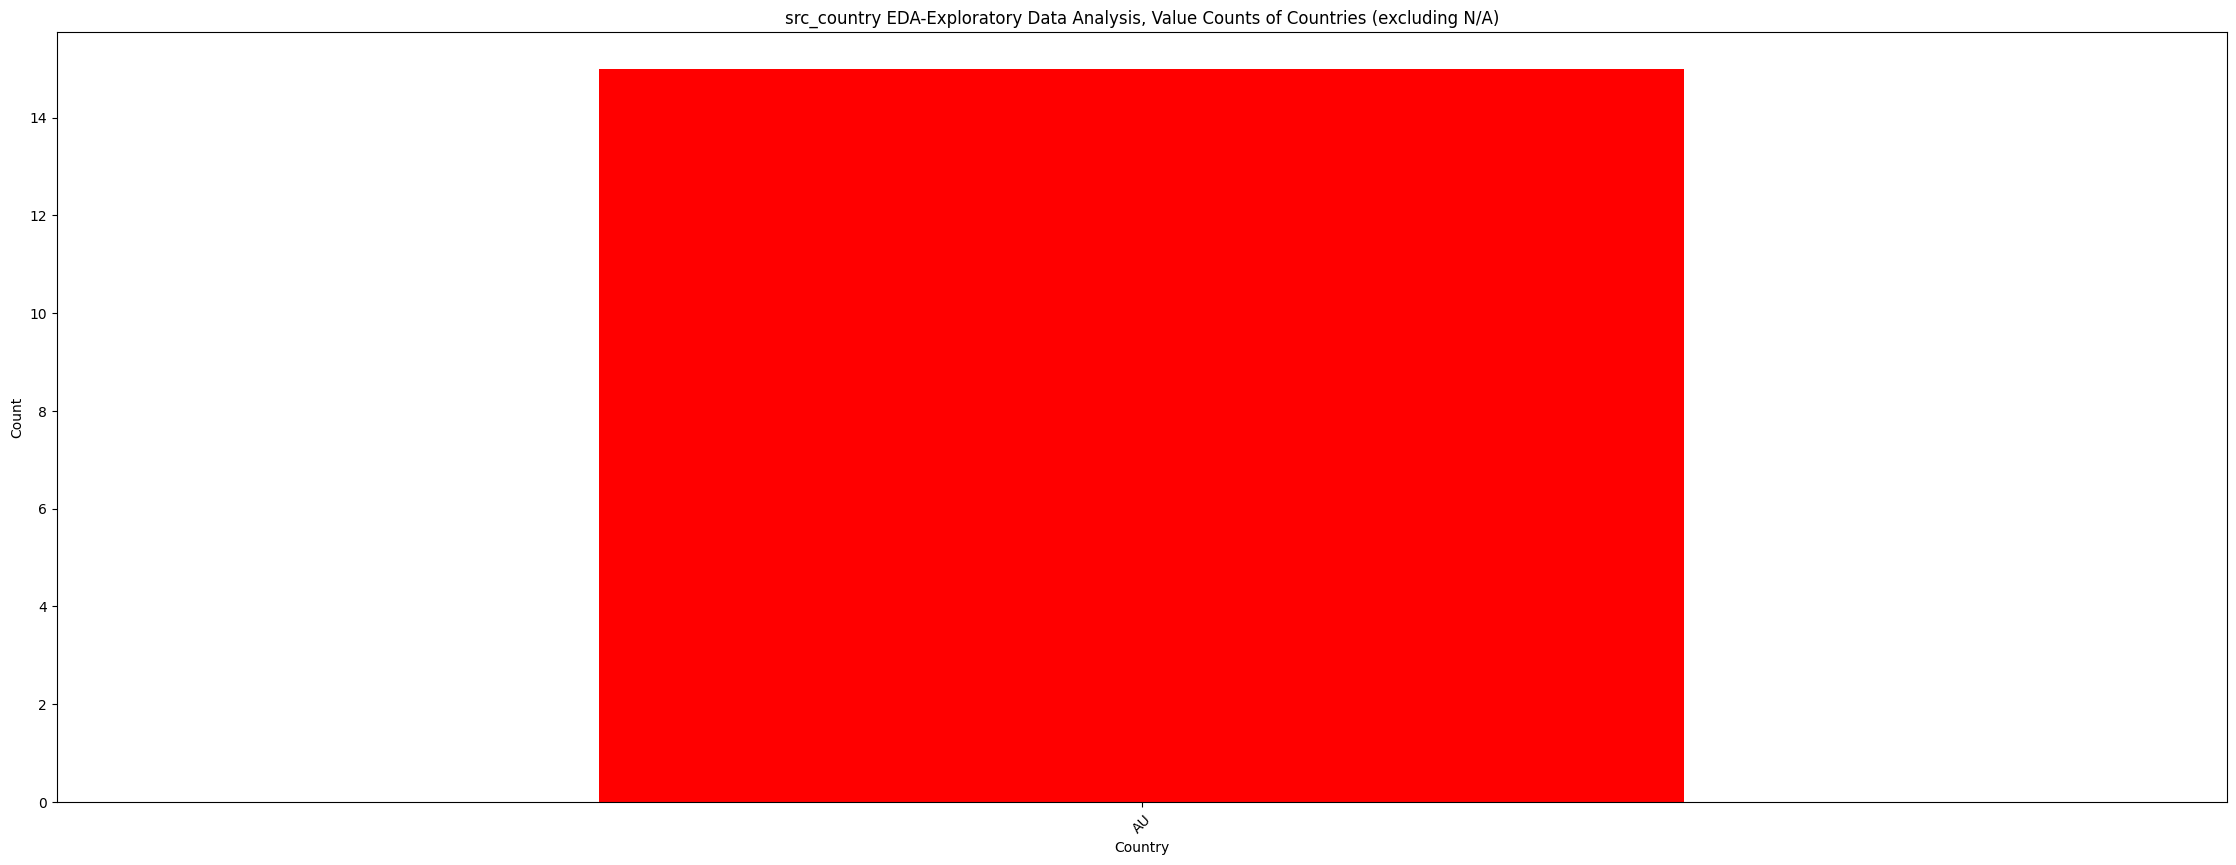

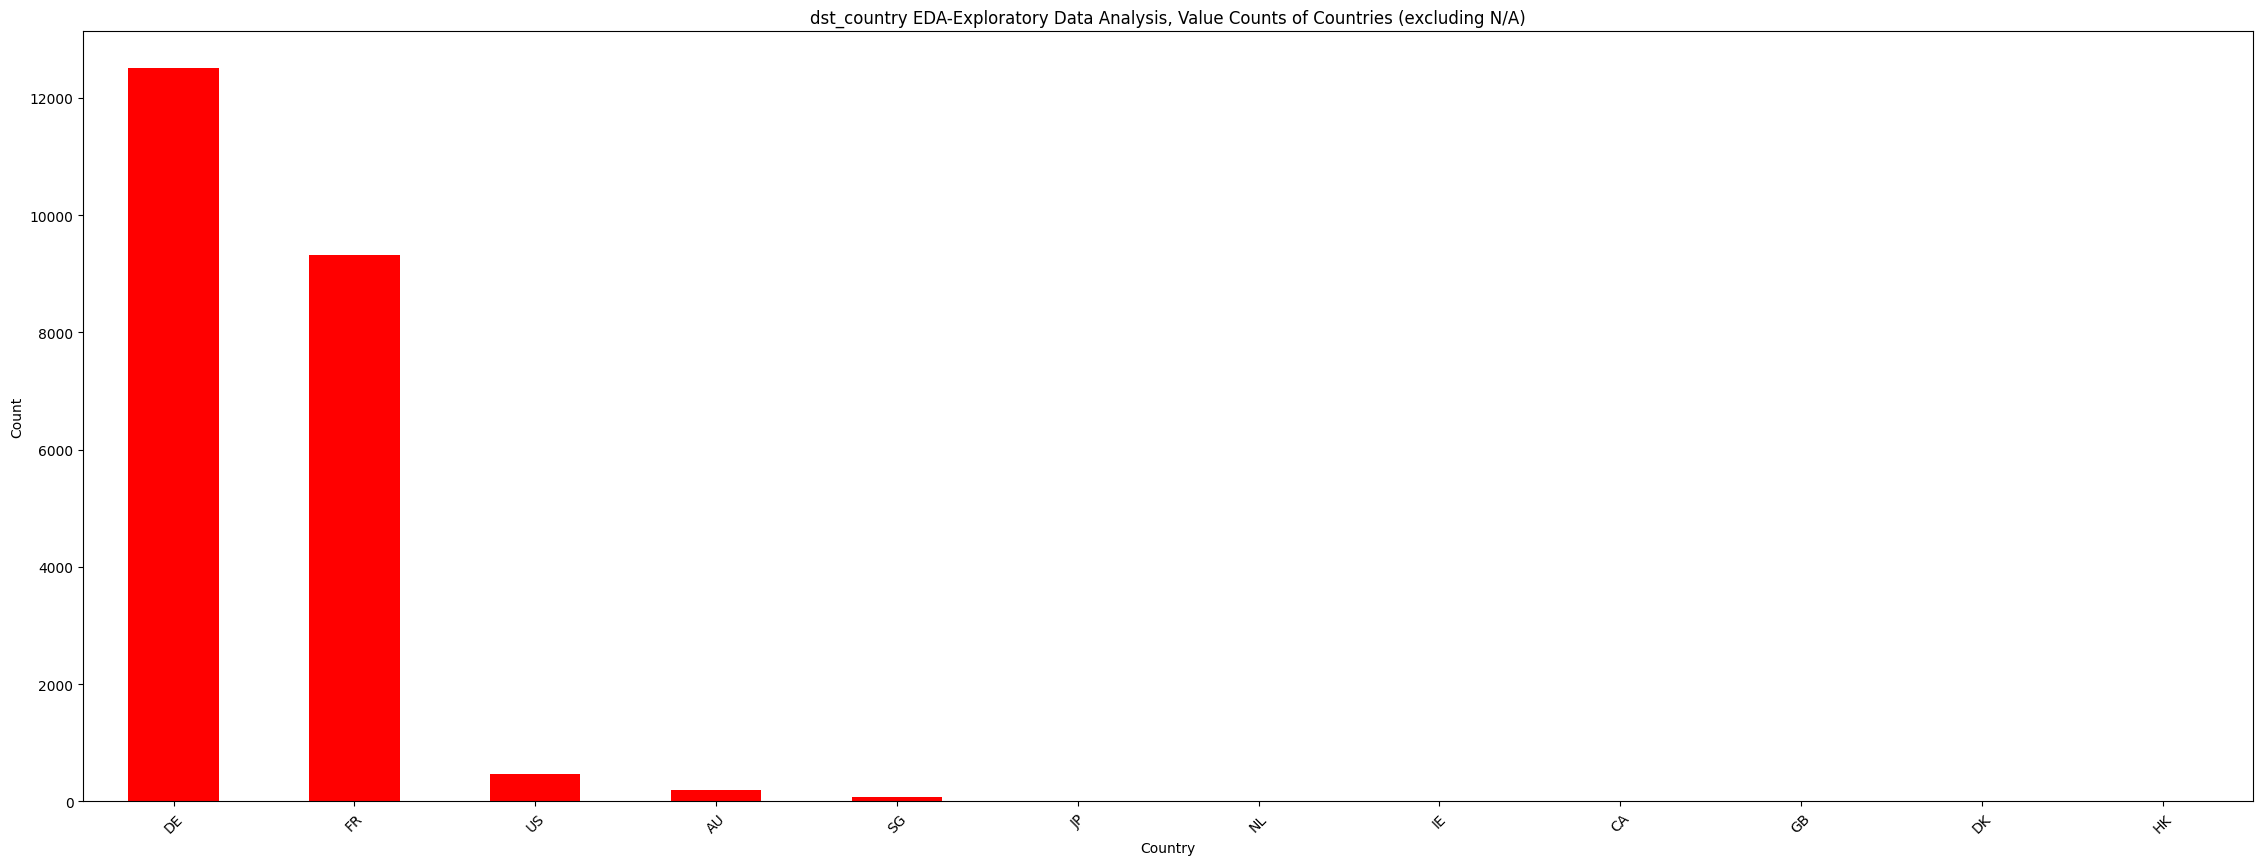

In [ ]:
#Plots - visually representing traffic origination country and destination country to monitor red flags.
# Create a sub DataFrame where column 'label' has value 1 or in other words we filter and plot just attack - possitive records on the network dataframe
subattack_network = network[network['label'] == 1]

IP_source = ['src_country', 'dst_country']
for i in IP_source:
  country_counts = subattack_network[i][subattack_network[i] != 'N/A'].value_counts()

  # Create a bar plot
  plt.figure(figsize=(28, 10))
  country_counts.plot(kind='bar', color='red')
  plt.xlabel('Country')
  plt.ylabel('Count')
  #title_text = f"{i} {static_title}"
  title_text = f"{i} {'EDA-Exploratory Data Analysis, Value Counts of Countries (excluding N/A)'}"
  plt.title(title_text)
  plt.xticks(rotation=45)  # Rotate x-axis labels if needed
  plt.show()



In [8]:
#Dropping Columns, largely because they have "-" on overwhelming majority of entries which makes is ineligible for analysis or no value in imputing.
# (or) verbose to the extent there are so many unique values which makes is unnecessary. 28 fields seems to be eligible to be inclused for analysis.
net_df = network.drop(['src_ip', 'dst_ip', 'weird_notice', 'weird_addl', 'weird_name', 'http_trans_depth',
       'http_method', 'http_uri', 'http_version', 'http_request_body_len',
       'http_response_body_len', 'http_status_code', 'http_user_agent',
       'http_orig_mime_types', 'http_resp_mime_types', 'ssl_cipher',
       'ssl_subject', 'dns_query', 'ssl_issuer', 'src_port', 'dst_port', 'dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected', 'ssl_version', 'ssl_established', 'ssl_resumed'], axis=1)

#Below code is used in EDA(exploratory data analysis to review what columns can be dropped for analysis.)
#list1 = net_df.columns
#for i in list1:
#  print ('#### field: ####', i)
#  print (net_df[i].value_counts())
#ISO 8601 Timestamps:   Prepping the column 'ts' which is in epoc seconds to human readable time stamps.
#YYYY-MM-DD HH:MM:SS (e.g., '2023-09-26 15:30:00') (Human readable Format)
net_df['date'] = pd.to_datetime(net_df['ts'], unit='s')
#print('Date stampe', net_df['date'])
net_df = net_df.set_index('date')
net_df = net_df.drop(['ts'], axis=1)
print(net_df.columns)
print(net_df.shape)



Index(['proto', 'service', 'duration', 'src_bytes', 'dst_bytes', 'conn_state',
       'missed_bytes', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes',
       'dns_qclass', 'dns_qtype', 'dns_rcode', 'label', 'type', 'src_country',
       'dst_country'],
      dtype='object')
(461043, 18)


In [10]:
#Below code is used in EDA(exploratory data analysis to review what columns can be dropped for analysis.)
net_df['service'] = net_df['service'].replace('-', 'Unknown')
net_df.head()



,proto,service,duration,src_bytes,dst_bytes,conn_state,missed_bytes,src_pkts,src_ip_bytes,dst_pkts,dst_ip_bytes,dns_qclass,dns_qtype,dns_rcode,label,type,src_country,dst_country
date,,,,,,,,,,,,,,,,,,
2019-04-02 09:45:58,tcp,Unknown,80549.530260,1762852,41933215,OTH,0,252181,14911156,2,236,0,0,0,0,normal,DE,N/A
2019-04-02 09:45:58,udp,Unknown,0.000000,0,0,S0,0,1,63,0,0,0,0,0,0,normal,N/A,N/A
2019-04-02 09:45:59,tcp,Unknown,0.000000,0,0,OTH,0,0,0,0,0,0,0,0,0,normal,N/A,N/A
2019-04-02 09:45:59,tcp,Unknown,0.000000,0,0,OTH,0,0,0,0,0,0,0,0,0,normal,N/A,N/A
2019-04-02 09:46:02,udp,dns,0.000549,0,298,SHR,0,0,0,2,354,0,0,0,0,normal,N/A,N/A


In [11]:
#EDA initiative to understand data
netsc_df = net_df.drop(['type', 'src_country',	'dst_country'], axis=1)
print(netsc_df.shape)
netsc_df.tail()

(461043, 15)


,proto,service,duration,src_bytes,dst_bytes,conn_state,missed_bytes,src_pkts,src_ip_bytes,dst_pkts,dst_ip_bytes,dns_qclass,dns_qtype,dns_rcode,label
date,,,,,,,,,,,,,,,
2019-04-27 04:54:22,tcp,Unknown,0.000000,0,0,S0,0,1,60,0,0,0,0,0,1
2019-04-28 03:49:50,tcp,Unknown,0.000000,0,0,OTH,0,0,0,1,103,0,0,0,1
2019-04-28 07:30:03,tcp,Unknown,290.371539,101568,2592,OTH,0,108,108064,31,3832,0,0,0,1
2019-04-29 12:20:42,tcp,Unknown,23.190902,32,31,SF,0,8,411,7,395,0,0,0,1
2019-04-29 12:20:42,tcp,Unknown,22.872314,32,31,SF,0,8,411,6,343,0,0,0,1


In [12]:
print(netsc_df['conn_state'].value_counts())

SF        123512
S0        113495
OTH       111842
REJ        45036
SHR        22053
SH         18138
S1         13843
S3          6642
RSTR        2360
RSTRH       1724
RSTO        1518
S2           708
RSTOS0       172
Name: conn_state, dtype: int64


In [13]:
##
#establishing Baseline accuracy
##
Baccuracy = 0.0
print('Majority of network traffic is normal indicated by label 0, attach traffic is indicated by label 1')
print(netsc_df['label'].value_counts(normalize=True))
majority_class = netsc_df['label'].value_counts().idxmax()
baseline_predictions = [majority_class] * len(netsc_df['label'])
#Calculate the accuracy of the baseline model:
Baccuracy = accuracy_score(netsc_df['label'], baseline_predictions)
print("Baseline Accuracy:", Baccuracy)

Majority of network traffic is normal indicated by label 0, attach traffic is indicated by label 1
0    0.650699
1    0.349301
Name: label, dtype: float64
Baseline Accuracy: 0.6506985248664441


In [14]:
netsc_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 461043 entries, 2019-04-02 09:45:58 to 2019-04-29 12:20:42
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   proto         461043 non-null  object 
 1   service       461043 non-null  object 
 2   duration      461043 non-null  float64
 3   src_bytes     461043 non-null  int64  
 4   dst_bytes     461043 non-null  int64  
 5   conn_state    461043 non-null  object 
 6   missed_bytes  461043 non-null  int64  
 7   src_pkts      461043 non-null  int64  
 8   src_ip_bytes  461043 non-null  int64  
 9   dst_pkts      461043 non-null  int64  
 10  dst_ip_bytes  461043 non-null  int64  
 11  dns_qclass    461043 non-null  int64  
 12  dns_qtype     461043 non-null  int64  
 13  dns_rcode     461043 non-null  int64  
 14  label         461043 non-null  int64  
dtypes: float64(1), int64(11), object(3)
memory usage: 56.3+ MB


In [ ]:
#'l1': L1 regularization (Lasso regularization)
X_train, X_test, y_train, y_test = train_test_split(netsc_df.drop(['label'], axis = 1), netsc_df['label'], random_state = 442,
                                                   stratify = netsc_df['label'])
lgr_accuracy = 0
selector = ''
#selector = ['src_country', 'dst_country', 'dns_rcode', 'dns_qtype', 'dns_qclass', 'conn_state', 'service', 'proto']
selector = ['dns_rcode', 'dns_qtype', 'dns_qclass', 'conn_state', 'service', 'proto']
ransformer = ''
transformer = make_column_transformer((OneHotEncoder(drop = 'first'), selector),
                                     remainder = StandardScaler())
extractor = ''
extractor = SelectFromModel(LogisticRegression(penalty='l1', solver = 'liblinear' ,random_state = 42))
lgr_pipe = ''
pipe_1_acc = ''
lgr_pipe = Pipeline([('transformer', transformer),
                    ('selector', extractor),
                    ('lgr', LogisticRegression(random_state=42, max_iter = 5000))])

lgr_pipe.fit(X_train, y_train)

pipe_1_acc = lgr_pipe.score(X_test, y_test)
lgr_predictions = lgr_pipe.predict(X_test)
lgr_accuracy = accuracy_score(y_test, lgr_predictions)
print(lgr_pipe)
print("Baseline Accuracy:", Baccuracy)
print("Pipeline Accuracy:", lgr_accuracy)
print("lgr L1 score:", pipe_1_acc)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['dns_rcode', 'dns_qtype',
                                                   'dns_qclass', 'conn_state',
                                                   'service', 'proto'])])),
                ('selector',
                 SelectFromModel(estimator=LogisticRegression(penalty='l1',
                                                              random_state=42,
                                                              solver='liblinear'))),
                ('lgr', LogisticRegression(max_iter=5000, random_state=42))])
Baseline Accuracy: 0.6506985248664441
Pipeline Accuracy: 0.8598571936734889
lgr L1 score: 0.8598571936734889


Pipeline Accuracy: 0.8598571936734889


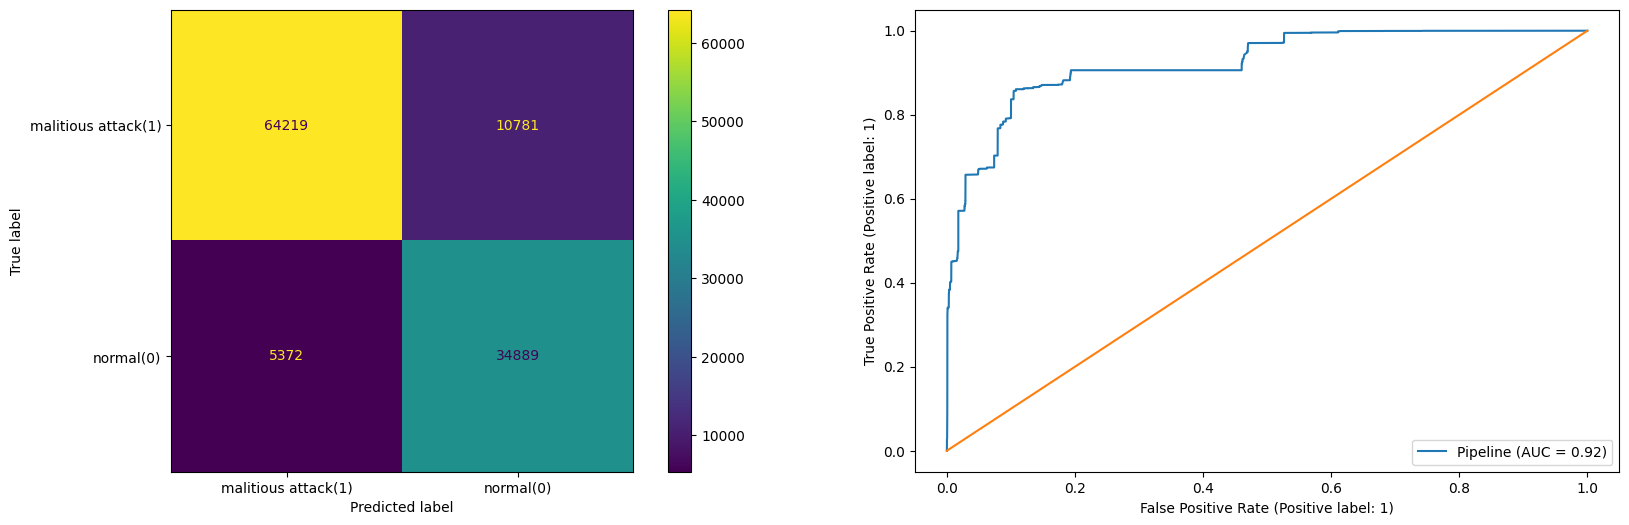

In [ ]:
fp = ''
fn = ''
auc = ''

fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ConfusionMatrixDisplay.from_estimator(lgr_pipe, X_test, y_test, ax = ax[0], display_labels = ['malitious attack(1)', 'normal(0)'])
RocCurveDisplay.from_estimator(lgr_pipe, X_test, y_test, ax = ax[1])
ax[1].plot(np.array([0, 1]), np.array([0, 1]))
#     Confusion Matrix

#     |64219 | 10781
#  0  |(TN)  | (FP)
#   --------------     y-axis Truth
#     |5372  | 34889
#  1  |(FN)  | (TP)
#   --------------
#        0   |  1
#      (x-axis Predicted)
################################
#   (x,y) co-ordinates
#   TN(0,0) True negative (normal network traffic), model predicted not an attack 64219 and it was truely normal traffic
#   TP(1,1) True positive (network attack), model predicted an attack 34889 and it was truely an attack
#   FN(0,1) False negative Model predicted (normal network traffic) 5372, but was actually an attack.
#   FP(1,0) False possitive model predicted (network attack) 10781, but was actually normal.

# For our scenario we need to tweak the model to reduce the FN(False negative) to gain more model confidence.
# So when the model says normal it can not be an attack.  ( number 5372 at FN(0,1) needs to be reduced )
################################
lgr_predictions = lgr_pipe.predict(X_test)
accuracy = accuracy_score(y_test, lgr_predictions)
print("Pipeline Accuracy:", accuracy)
auc = float(round(accuracy, 2))
###############################
#Here's how you can use the ROC curve to minimize false negatives:
#Threshold Selection: The ROC curve illustrates the trade-off between sensitivity (true positive rate) and specificity (true negative rate)
#across different threshold settings. By adjusting the classification threshold, you can control the balance between false positives and false negatives.

#Desired Sensitivity: If your goal is to minimize false negatives (e.g., in a medical diagnosis or cyber threats where missing a positive case is costly), you can select
# a threshold that corresponds to a high sensitivity on the ROC curve. This threshold will maximize the true positive rate and minimize false negatives.

#Evaluate Trade-offs: Keep in mind that as you increase sensitivity (reduce false negatives), you may also increase false positives. The ROC curve helps
#you visualize and evaluate these trade-offs. You can choose a threshold that aligns with your specific requirements and risk tolerance.

#area Under the ROC Curve (AUC-ROC): The AUC-ROC value can also provide insights into the model's ability to minimize false negatives.
#A higher AUC-ROC indicates better discrimination between positive and negative classes, which generally means the model is better at minimizing false negatives.

#In summary, while the ROC curve itself does not directly minimize false negatives, it provides a visual representation of the model's sensitivity and its
#trade-off with specificity. You can use this information to select an appropriate threshold or evaluate the model's performance with respect to minimizing
#false negatives in your specific application.









In [ ]:

#'l2': L2 regularization (Ridge regularization)

X_train, X_test, y_train, y_test = train_test_split(netsc_df.drop(['label'], axis = 1), netsc_df['label'], random_state = 442,
                                                   stratify = netsc_df['label'])
lgr_accuracy = 0
selector = ''
#selector = ['src_country', 'dst_country', 'dns_rcode', 'dns_qtype', 'dns_qclass', 'conn_state', 'service', 'proto']
selector = ['dns_rcode', 'dns_qtype', 'dns_qclass', 'conn_state', 'service', 'proto']
ransformer = ''
transformer = make_column_transformer((OneHotEncoder(drop = 'first'), selector),
                                     remainder = StandardScaler())
extractor = ''
extractor = SelectFromModel(LogisticRegression(penalty='l2', solver = 'liblinear' ,random_state = 42))
lgr_pipe2 = ''
pipe_2_acc = ''
lgr_pipe2 = Pipeline([('transformer', transformer),
                    ('selector', extractor),
                    ('lgr', LogisticRegression(random_state=42, max_iter = 5000))])

lgr_pipe2.fit(X_train, y_train)

pipe_2_acc = lgr_pipe2.score(X_test, y_test)
lgr_predictions2 = lgr_pipe2.predict(X_test)
lgr_accuracy2 = accuracy_score(y_test, lgr_predictions2)
print(lgr_pipe2)
print("Baseline Accuracy:", Baccuracy)
print("Pipeline Accuracy:", lgr_accuracy2)
print("lgr L2 score:", pipe_2_acc)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['dns_rcode', 'dns_qtype',
                                                   'dns_qclass', 'conn_state',
                                                   'service', 'proto'])])),
                ('selector',
                 SelectFromModel(estimator=LogisticRegression(random_state=42,
                                                              solver='liblinear'))),
                ('lgr', LogisticRegression(max_iter=5000, random_state=42))])
Baseline Accuracy: 0.6506985248664441
Pipeline Accuracy: 0.8596489705971664
lgr L2 score: 0.8596489705971664


In [15]:
netsc_df.head()

,proto,service,duration,src_bytes,dst_bytes,conn_state,missed_bytes,src_pkts,src_ip_bytes,dst_pkts,dst_ip_bytes,dns_qclass,dns_qtype,dns_rcode,label
date,,,,,,,,,,,,,,,
2019-04-02 09:45:58,tcp,Unknown,80549.530260,1762852,41933215,OTH,0,252181,14911156,2,236,0,0,0,0
2019-04-02 09:45:58,udp,Unknown,0.000000,0,0,S0,0,1,63,0,0,0,0,0,0
2019-04-02 09:45:59,tcp,Unknown,0.000000,0,0,OTH,0,0,0,0,0,0,0,0,0
2019-04-02 09:45:59,tcp,Unknown,0.000000,0,0,OTH,0,0,0,0,0,0,0,0,0
2019-04-02 09:46:02,udp,dns,0.000549,0,298,SHR,0,0,0,2,354,0,0,0,0


In [16]:
netsc_df['service'] = netsc_df['service'].replace('Unknown', 'UN')
# Clean values in the DataFrame by stripping leading and trailing whitespace
netsc_df = netsc_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
columns_to_convert = ['proto', 'service', 'conn_state']
netsc_df[columns_to_convert] = netsc_df[columns_to_convert].astype(str)
netsc_df = netsc_df.reset_index(drop=True)
netsc_df.head()

,proto,service,duration,src_bytes,dst_bytes,conn_state,missed_bytes,src_pkts,src_ip_bytes,dst_pkts,dst_ip_bytes,dns_qclass,dns_qtype,dns_rcode,label
0,tcp,UN,80549.530260,1762852,41933215,OTH,0,252181,14911156,2,236,0,0,0,0
1,udp,UN,0.000000,0,0,S0,0,1,63,0,0,0,0,0,0
2,tcp,UN,0.000000,0,0,OTH,0,0,0,0,0,0,0,0,0
3,tcp,UN,0.000000,0,0,OTH,0,0,0,0,0,0,0,0,0
4,udp,dns,0.000549,0,298,SHR,0,0,0,2,354,0,0,0,0


In [17]:
# In sections above we used piplines to encode and implement standardscalar and transform columns.
# Below we will manually do the same encoding and standard scalar.
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Define which columns to one-hot encode and which to standard scale
one_hot_columns = ['dns_rcode', 'dns_qtype', 'dns_qclass', 'conn_state', 'service', 'proto']
scaler_columns = ['duration', 'src_bytes', 'dst_bytes', 'missed_bytes', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes']

# Create a column transformer without remainder='passthrough'
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first'), one_hot_columns),  # Apply OneHotEncoder to categorical columns
    (StandardScaler(), scaler_columns),              # Apply StandardScaler to numeric columns
    remainder='passthrough'
)

# Fit and transform the data using the column transformer
transformed_data = preprocessor.fit_transform(netsc_df)

# Get the feature names after transformation
feature_names = preprocessor.get_feature_names_out(input_features=netsc_df.columns)

# Convert the sparse matrix to a dense matrix
# converting data to array produced the output in desired format with the right number of clumns as opposed to 1 column with \n's and \t's
transformed_data = transformed_data.toarray()

# Create a DataFrame from the transformed data with column names
netclean_df = pd.DataFrame(transformed_data, columns=feature_names)



# The index will be maintained
print(netclean_df)
print(netclean_df.columns)



        onehotencoder__dns_rcode_1  onehotencoder__dns_rcode_2  \
0                              0.0                         0.0   
1                              0.0                         0.0   
2                              0.0                         0.0   
3                              0.0                         0.0   
4                              0.0                         0.0   
...                            ...                         ...   
461038                         0.0                         0.0   
461039                         0.0                         0.0   
461040                         0.0                         0.0   
461041                         0.0                         0.0   
461042                         0.0                         0.0   

        onehotencoder__dns_rcode_3  onehotencoder__dns_rcode_5  \
0                              0.0                         0.0   
1                              0.0                         0.0   
2        

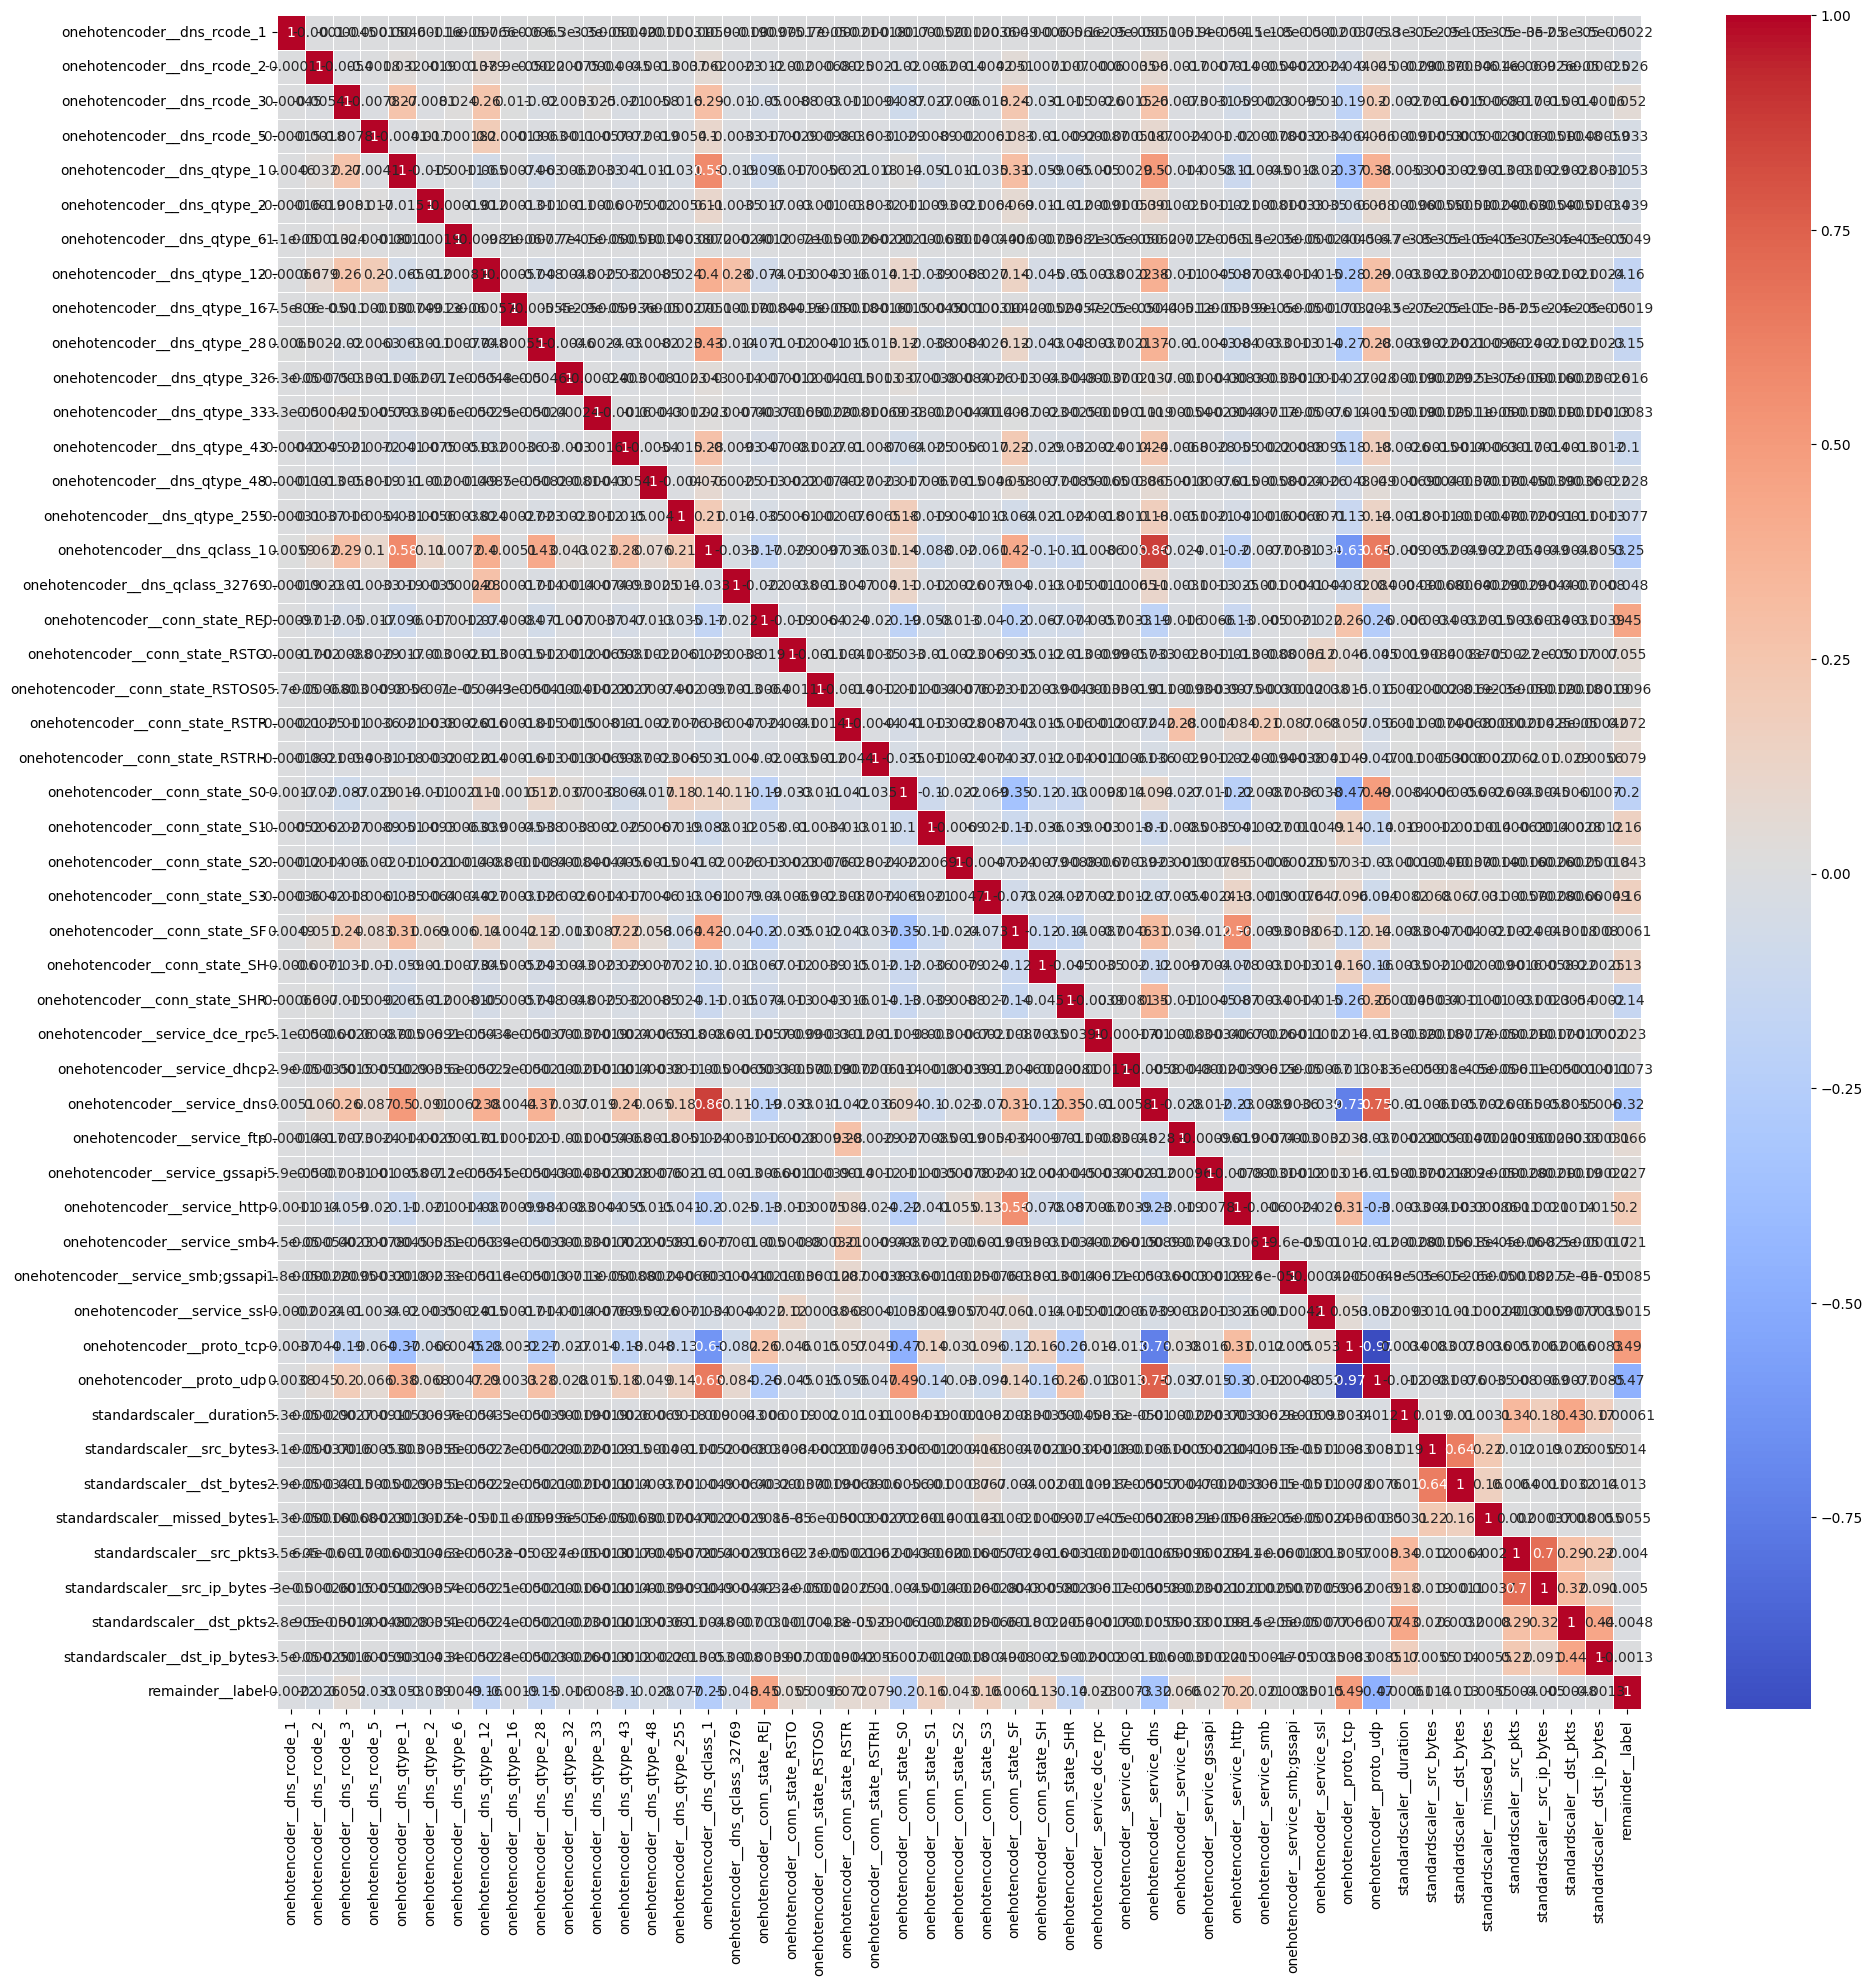

In [18]:
#Cleaned DataFrame to compute netclean_df
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = netclean_df.corr()
plt.figure(figsize=(22, 22))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

In [19]:
#CLeaned DataFrame to compute netclean_df
#Output is too many to make any meaningful decision.
#So we need to come up with an alternate approach to reduce feature sets.
#Perhaps manual setting threshold value and examining correlation_matrix.
# Define a correlation threshold and reducing features to minimize computational expense and model analysis stability.
correlation_threshold = 0.7

# Find pairs of highly correlated features
correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

# Drop/print the highly correlated features
print('highly - corelated features', correlated_features)
print('******************************************************************************************************************')
netclean_redf_df = netclean_df.drop(columns=correlated_features)
print(netclean_df.columns)
print(netclean_df.shape)
print('==>>')
print(netclean_redf_df.shape)
print(netclean_redf_df.columns)

# Output from multiple steps above can now be stored as a CSV file to lod it for later quick use cases going forward.

from google.colab import files
netclean_redf_df.to_csv('/content/drive/My Drive/Colab Notebooks/AIML/capstone/capstone-dataset/netclean_redf_df.csv', encoding = 'utf-8-sig')

highly - corelated features {'onehotencoder__proto_tcp', 'onehotencoder__service_dns', 'onehotencoder__proto_udp'}
******************************************************************************************************************
Index(['onehotencoder__dns_rcode_1', 'onehotencoder__dns_rcode_2',
       'onehotencoder__dns_rcode_3', 'onehotencoder__dns_rcode_5',
       'onehotencoder__dns_qtype_1', 'onehotencoder__dns_qtype_2',
       'onehotencoder__dns_qtype_6', 'onehotencoder__dns_qtype_12',
       'onehotencoder__dns_qtype_16', 'onehotencoder__dns_qtype_28',
       'onehotencoder__dns_qtype_32', 'onehotencoder__dns_qtype_33',
       'onehotencoder__dns_qtype_43', 'onehotencoder__dns_qtype_48',
       'onehotencoder__dns_qtype_255', 'onehotencoder__dns_qclass_1',
       'onehotencoder__dns_qclass_32769', 'onehotencoder__conn_state_REJ',
       'onehotencoder__conn_state_RSTO', 'onehotencoder__conn_state_RSTOS0',
       'onehotencoder__conn_state_RSTR', 'onehotencoder__conn_state_RSTR

In [ ]:
# Initial Analysis using SVM Support Vector Machine - modeling.
# Initial analysis with various paramaters and output was recorded. (summary  is captured at the bottom of this code section)

from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
netclean_redf_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AIML/capstone/capstone-dataset/netclean_redf_df.csv')

X = netclean_redf_df.drop('remainder__label', axis=1)
y = netclean_redf_df['remainder__label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=500, random_state=42)
start_time1 = time.time()
rf.fit(X_train, y_train)
end_time1 = time.time()

#Select Important Features:
#Use the trained Random Forest to select the most important features.
#You can choose a threshold to determine how many features to keep based on feature importance scores.
sfm = SelectFromModel(rf, threshold=0.05)  # Adjust the threshold as needed
sfm.fit(X_train, y_train)
X_train_reduced = sfm.transform(X_train)
X_test_reduced = sfm.transform(X_test)
#Train an SVC on the Reduced Feature Set:
svc = SVC()
start_time2 = time.time()
svc.fit(X_train_reduced, y_train)
end_time2 = time.time()

#Evaluate the Model:
accuracy = svc.score(X_test_reduced, y_test)
y_pred = svc.predict(X_test_reduced)
balanced_accuracy = np.mean(y_test == y_pred)
##>>>>>>>
# Get the selected feature indices
selected_feature_indices = sfm.get_support(indices=True)

# Get the original column names from the DataFrame
original_feature_names = X.columns

# Create a list of reduced feature names
reduced_feature_names = [original_feature_names[i] for i in selected_feature_indices]

# Print the reduced feature names
print("Reduced Feature Names:")
for feature in reduced_feature_names:
    print(feature)
##>>>>>>>>

print(f"Accuracy on the testing set: {accuracy}")

# Print results
model_name = 'RandomForestClassifier(FeatureReduction)+SVC'
print(f"Model: {model_name}")
print(f"Fit Time: {(end_time2 - start_time2) + (end_time1 - start_time1):.4f} seconds")
print(f"Model: {model_name}")
print(f"Balanced Accuracy: {balanced_accuracy:.4f}")

#>>>> Captured Results Ist successful run.
#Reduced Feature Names:
#onehotencoder__conn_state_REJ
#standardscaler__src_bytes
#standardscaler__dst_bytes
#standardscaler__src_pkts
#standardscaler__src_ip_bytes
#standardscaler__dst_pkts
#standardscaler__dst_ip_bytes
#Accuracy on the testing set: 0.7478987951284581
#Model: RandomForestClassifier(FeatureReduction)+SVC
#Fit Time: 9727.4670 seconds
#Model: RandomForestClassifier(FeatureReduction)+SVC
#Balanced Accuracy: 0.7479

#>>>>>>>>>>
# Runtime penalty too high and RandomForestClassifier(FeatureReduction)+SVC model accuracy is too low for model consideration.
#>>>>>>>>>>


In [ ]:
import time
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from google.colab import drive
drive.mount('/content/drive')

netclean_redf_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AIML/capstone/capstone-dataset/netclean_redf_df.csv')

y = netclean_df['remainder__label']
X = netclean_df.drop(columns=['remainder__label'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a list of models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=5000),
    'Decision Tree': DecisionTreeClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    #'Support Vector Machine': SVC() # Support Vector Machine is computationally expensive, disabling it to execute it seperately on its own, potentially reducing features.
}

# Initialize lists to store evaluation results
model_names = []
balanced_accuracy_scores = []
fit_times = []
interpretability = []

# Loop through each model
for model_name, model in models.items():
    # Measure time to train the model
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()

    # Calculate balanced accuracy score (good for imbalanced classes)
    y_pred = model.predict(X_test)
    balanced_accuracy = np.mean(y_test == y_pred)

    # Evaluate interpretability (you can customize this based on your criteria)
    # Here, we'll use a simple check if the model is a decision tree or logistic regression
    interpretable = isinstance(model, DecisionTreeClassifier) or isinstance(model, LogisticRegression)

    # Store results
    model_names.append(model_name)
    balanced_accuracy_scores.append(balanced_accuracy)
    fit_times.append(end_time - start_time)
    interpretability.append(interpretable)

    # Print results
    print(f"Model: {model_name}")
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
    print(f"Fit Time: {end_time - start_time:.4f} seconds")
    print(f"Interpretable: {'Yes' if interpretable else 'No'}\n")

# Create a DataFrame to summarize results
results_df = pd.DataFrame({
    'Model': model_names,
    'Balanced Accuracy': balanced_accuracy_scores,
    'Fit Time (s)': fit_times,
    'Interpretable': interpretability
})

# Print the summary results
print("Summary Results:")
print(results_df)
results_df.head()

#Results from a succesful run
#Model: Logistic Regression
#Balanced Accuracy: 0.8594
#Fit Time: 26.5124 seconds
#Interpretable: Yes

#Model: Decision Tree
#Balanced Accuracy: 0.9914
#Fit Time: 2.1560 seconds
#Interpretable: Yes

#Model: K-Nearest Neighbors
#Balanced Accuracy: 0.9881
#Fit Time: 0.0453 seconds
#Interpretable: No

In [ ]:
import time
import numpy as np
import pandas as pd
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from google.colab import drive
drive.mount('/content/drive')

netclean_redf_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AIML/capstone/capstone-dataset/netclean_redf_df.csv')

X = netclean_redf_df.drop('remainder__label', axis=1)
y = netclean_redf_df['remainder__label']

# Subsample the data to 30% while preserving the balance of the target variable
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.7, random_state=42, stratify=y)

# Split the remaining data into training and testing sets
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Define a list of models with their respective parameter grids for HalvingGridSearchCV
models = {
    'K-Nearest Neighbors': (KNeighborsClassifier(n_jobs=-1), {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    }),
    'Logistic Regression': (LogisticRegression(max_iter=5000), {
        'C': np.logspace(-3, 3, 100),
        'penalty': ['l1', 'l2', 'elasticnet'],
        'max_iter': np.arange(100, 5000, 100)
    }),
    'Decision Tree': (DecisionTreeClassifier(), {
        'max_depth': [None, 10, 20, 30, 40],
        'min_samples_split': np.arange(2, 11),
        'min_samples_leaf': np.arange(1, 5)
    })
}

# Initialize lists to store evaluation results
model_names = []
balanced_accuracy_scores = []
fit_times = []
interpretability = []
best_params_list = []

# Loop through each model
for model_name, (model, param_grid) in models.items():
    # Use HalvingGridSearchCV to find the best parameters
    halving_grid_search = HalvingGridSearchCV(model, param_grid, scoring='balanced_accuracy', cv=5, factor=3, random_state=42)

    # Measure time to perform HalvingGridSearchCV
    start_time = time.time()
    halving_grid_search.fit(X_train, y_train)
    end_time = time.time()

    # Get the best parameters and set them in the model
    best_params = halving_grid_search.best_params_
    model.set_params(**best_params)

    # Measure time to train the model with the best parameters
    start_time_fit = time.time()
    model.fit(X_train, y_train)
    end_time_fit = time.time()

    # Calculate balanced accuracy score (good for imbalanced classes)
    y_pred = model.predict(X_test)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

    # Evaluate interpretability (you can customize this based on your criteria)
    interpretable = isinstance(model, DecisionTreeClassifier) or isinstance(model, LogisticRegression)

    # Store results
    model_names.append(model_name)
    balanced_accuracy_scores.append(balanced_accuracy)
    fit_times.append(end_time_fit - start_time_fit)
    interpretability.append(interpretable)
    best_params_list.append(best_params)

    # Print results including best parameters
    print(f"Model: {model_name}")
    print(f"Best Parameters: {best_params}")
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
    print(f"Fit Time: {end_time_fit - start_time_fit:.4f} seconds")
    print(f"Interpretable: {'Yes' if interpretable else 'No'}\n")

# Create a DataFrame to summarize results
results_df = pd.DataFrame({
    'Model': model_names,
    'Best Parameters': best_params_list,
    'Balanced Accuracy': balanced_accuracy_scores,
    'Fit Time (s)': fit_times,
    'Interpretable': interpretability
})

# Print the summary results
print("Summary Results:")
print(results_df)

# Initial succesful run results
#Model: K-Nearest Neighbors
#Best Parameters: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
#Balanced Accuracy: 0.9891
#Fit Time: 0.0179 seconds
#Interpretable: No

#Model: Logistic Regression
#Best Parameters: {'C': 70.54802310718645, 'max_iter': 100, 'penalty': 'l2'}
#Balanced Accuracy: 0.8085
#Fit Time: 3.5397 seconds
#Interpretable: Yes

#Model: Decision Tree
#Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
#Balanced Accuracy: 0.9885
#Fit Time: 0.7924 seconds
#Interpretable: Yes

#Summary Results:
#                 Model                                    Best Parameters  \
#0  K-Nearest Neighbors  {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
#1  Logistic Regression  {'C': 70.54802310718645, 'max_iter': 100, 'pen...
#2        Decision Tree  {'max_depth': 20, 'min_samples_leaf': 1, 'min_...

#   Balanced Accuracy  Fit Time (s)  Interpretable
#0           0.989068      0.017862          False
#1           0.808486      3.539652           True
#2           0.988458      0.792380           True

Model: K-Nearest Neighbors
Best Parameters: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Balanced Accuracy: 0.9891
Fit Time: 0.0179 seconds
Interpretable: No



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
49000 fits failed out of a total of 73500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24500 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueErr

Model: Logistic Regression
Best Parameters: {'C': 70.54802310718645, 'max_iter': 100, 'penalty': 'l2'}
Balanced Accuracy: 0.8085
Fit Time: 3.5397 seconds
Interpretable: Yes

Model: Decision Tree
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Balanced Accuracy: 0.9885
Fit Time: 0.7924 seconds
Interpretable: Yes

Summary Results:
                 Model                                    Best Parameters  \
0  K-Nearest Neighbors  {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}   
1  Logistic Regression  {'C': 70.54802310718645, 'max_iter': 100, 'pen...   
2        Decision Tree  {'max_depth': 20, 'min_samples_leaf': 1, 'min_...   

   Balanced Accuracy  Fit Time (s)  Interpretable  
0           0.989068      0.017862          False  
1           0.808486      3.539652           True  
2           0.988458      0.792380           True  


In [ ]:
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score

from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
netclean_redf_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AIML/capstone/capstone-dataset/netclean_redf_df.csv')

X = netclean_redf_df.drop('remainder__label', axis=1)
y = netclean_redf_df['remainder__label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random forest classifier
rfc = RandomForestClassifier(random_state=42, class_weight='balanced')

# Use SelectFromModel to select important features
sfm = SelectFromModel(rfc, threshold='median')
X_important_train = sfm.fit_transform(X_train, y_train)
X_important_test = sfm.transform(X_test)

#>>>> Reduced/best feature set, grid search on Random Foresst Classifier

# Get the selected feature indices
selected_feature_indices = sfm.get_support(indices=True)

# Get the original column names from the DataFrame
original_feature_names = X.columns

# Create a list of reduced feature names
reduced_feature_names = [original_feature_names[i] for i in selected_feature_indices]

# Print the reduced feature names
print("Reduced Feature Names:")
for feature in reduced_feature_names:
    print(feature)


# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Use GridSearchCV with balanced accuracy as the scoring metric
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring='balanced_accuracy', cv=5)
grid_search.fit(X_important_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the model with the best parameters
best_rfc = RandomForestClassifier(**best_params, random_state=42, class_weight='balanced')
start_time = time.time()
best_rfc.fit(X_important_train, y_train)
end_time = time.time()

# Make predictions and evaluate the model
y_pred = best_rfc.predict(X_important_test)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print('Model: RandomForestClassifier' )
print('\n')
# Print the best parameters and the balanced accuracy
print("Best parameters: ", best_params)
print('\n')
print('Model: RandomForestClassifier')
print('Balanced accuracy:', balanced_acc)
print('Fit Time:', end_time - start_time)
print('Interpretable: No')
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
#Results from a succesful run
#Reduced Feature Names:
#onehotencoder__dns_rcode_3
#onehotencoder__dns_qtype_1
#onehotencoder__dns_qtype_12
#onehotencoder__dns_qtype_28
#onehotencoder__dns_qclass_1
#onehotencoder__conn_state_REJ
#onehotencoder__conn_state_RSTRH
#onehotencoder__conn_state_S0
#onehotencoder__conn_state_S1
#onehotencoder__conn_state_S3
#onehotencoder__conn_state_SF
#onehotencoder__conn_state_SH
#onehotencoder__conn_state_SHR
#onehotencoder__service_dns
#onehotencoder__service_http
#onehotencoder__proto_tcp
#onehotencoder__proto_udp
#standardscaler__duration
#standardscaler__src_bytes
#standardscaler__dst_bytes
#standardscaler__src_pkts
#standardscaler__src_ip_bytes
#standardscaler__dst_pkts
#standardscaler__dst_ip_bytes


#Model: RandomForestClassifier
#Balanced accuracy: 0.9914977529688583
#Fit Time: 91.30639910697937
#Interpretable: No

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

In [ ]:
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score

y = netclean_df['remainder__label']
X = netclean_df.drop(columns=['remainder__label'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random forest classifier
rfc = RandomForestClassifier(random_state=42, class_weight='balanced')

# Fit the model on the training data
rfc.fit(X_train, y_train)

# Use SelectFromModel to select important features
sfm = SelectFromModel(rfc, threshold='median')
X_important_train = sfm.fit_transform(X_train, y_train)
X_important_test = sfm.transform(X_test)
#>>>> Reduced/best feature set, grid search on Random Foresst Classifier
# Get the feature importances
feature_importances = rfc.feature_importances_

# Get the indices of the top 15 features
top_15_indices = feature_importances.argsort()[-15:][::-1]

# Get the original column names from the DataFrame
original_feature_names = X.columns

# Create a list of the names of the top 15 features
top_15_feature_names = [original_feature_names[i] for i in top_15_indices]

# Print the top 15 feature names
print("Top 15 Feature Names:")
for feature_name in top_15_feature_names:
    print(feature_name)

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Use GridSearchCV with balanced accuracy as the scoring metric
X_top15_train = X_train[top_15_feature_names]
X_top15_test = X_test[top_15_feature_names]
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring='balanced_accuracy', cv=5)
grid_search.fit(X_top15_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the model with the best parameters
best_rfc = RandomForestClassifier(**best_params, random_state=42, class_weight='balanced')
start_time = time.time()
best_rfc.fit(X_top15_train, y_train)
end_time = time.time()

# Make predictions and evaluate the model
y_pred = best_rfc.predict(X_top15_test)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print('\n')
print('Model: RandomForestClassifier' )
print('\n')
# Print the best parameters and the balanced accuracy
print("Best parameters: ", best_params)
print('\n')
print('Model: RandomForestClassifier')
print('Balanced accuracy:', balanced_acc)
print('Fit Time:', end_time - start_time)
print('Interpretable: No')

#Results from Succesful run
#Top 15 Feature Names:
#standardscaler__src_ip_bytes
#standardscaler__src_pkts
#onehotencoder__proto_udp
#onehotencoder__proto_tcp
#standardscaler__dst_ip_bytes
#standardscaler__dst_pkts
#standardscaler__dst_bytes
#onehotencoder__conn_state_REJ
#standardscaler__src_bytes
#standardscaler__duration
#onehotencoder__service_dns
#onehotencoder__conn_state_S0
#onehotencoder__dns_rcode_3
#onehotencoder__dns_qclass_1
#onehotencoder__dns_qtype_1

#Model: RandomForestClassifier


#Best parameters:  {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}


#Model: RandomForestClassifier
#Balanced accuracy: 0.991113318071347
#Fit Time: 85.33337879180908
#Interpretable: No


Top 15 Feature Names:
standardscaler__src_ip_bytes
standardscaler__src_pkts
onehotencoder__proto_udp
onehotencoder__proto_tcp
standardscaler__dst_ip_bytes
standardscaler__dst_pkts
standardscaler__dst_bytes
onehotencoder__conn_state_REJ
standardscaler__src_bytes
standardscaler__duration
onehotencoder__service_dns
onehotencoder__conn_state_S0
onehotencoder__dns_rcode_3
onehotencoder__dns_qclass_1
onehotencoder__dns_qtype_1
Model: RandomForestClassifier


Best parameters:  {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}


Model: RandomForestClassifier
Balanced accuracy: 0.991113318071347
Fit Time: 85.33337879180908
Interpretable: No


In [ ]:
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score

#print(netclean_df.columns)
'''
# 24 Features is computationally expensive and takes multiple hours to complete to taking best 15 features to compute
red_imp_features = [
    'onehotencoder__dns_rcode_3',
    'onehotencoder__dns_qtype_1',
    'onehotencoder__dns_qtype_12',
    'onehotencoder__dns_qtype_28',
    'onehotencoder__dns_qclass_1',
    'onehotencoder__conn_state_REJ',
    'onehotencoder__conn_state_RSTRH',
    'onehotencoder__conn_state_S0',
    'onehotencoder__conn_state_S1',
    'onehotencoder__conn_state_S3',
    'onehotencoder__conn_state_SF',
    'onehotencoder__conn_state_SH',
    'onehotencoder__conn_state_SHR',
    'onehotencoder__service_dns',
    'onehotencoder__service_http',
    'onehotencoder__proto_tcp',
    'onehotencoder__proto_udp',
    'standardscaler__duration',
    'standardscaler__src_bytes',
    'standardscaler__dst_bytes',
    'standardscaler__src_pkts',
    'standardscaler__src_ip_bytes',
    'standardscaler__dst_pkts',
    'standardscaler__dst_ip_bytes'
]
'''
red_imp_features = [
    'standardscaler__src_ip_bytes',
    'standardscaler__src_pkts',
    'onehotencoder__proto_udp',
    'onehotencoder__proto_tcp',
    'standardscaler__dst_ip_bytes',
    'standardscaler__dst_pkts',
    'standardscaler__dst_bytes',
    'onehotencoder__conn_state_REJ',
    'standardscaler__src_bytes',
    'standardscaler__duration',
    'onehotencoder__service_dns',
    'onehotencoder__conn_state_S0',
    'onehotencoder__dns_rcode_3',
    'onehotencoder__dns_qclass_1',
    'onehotencoder__dns_qtype_1'
]

#print('Reduced Important Features to implement Support Vector Machine:', red_imp_features)

y = netclean_df['remainder__label']
X = netclean_df[red_imp_features]

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score

# Assuming you have X and y defined already

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {'C': [0.1, 1, 10],
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

# Create an SVM classifier
svm = SVC()

# Perform GridSearchCV
grid_search = GridSearchCV(svm, param_grid, scoring='balanced_accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_svm = grid_search.best_estimator_

# Fit the best estimator on the entire training set
start_time = time.time()
best_svm.fit(X_train, y_train)
end_time = time.time()

# Predict on the test set
y_pred = best_svm.predict(X_test)

# Calculate the balanced accuracy
balanced_acc = balanced_accuracy_score(y_test, y_pred)

# Print the best parameters and the balanced accuracy
print('\n')
print("Best parameters: ", best_params)
print('\n')
print('Model: Feature red RandomForestClassifier + SVM' )
print("Balanced accuracy:", balanced_acc)
print('Fit Time:', end_time - start_time)
print('Interpretable: No')
